In [2]:
import xarray as xr         # For handling NetCDF data
import numpy as np          # For array operations
import geopandas as gpd     # For geospatial dataframes and file I/O
from shapely.geometry import Point  # For creating point geometries
import xwrf
from shapely.geometry import shape
from shapely.ops import unary_union
import rasterio.features
from rasterio.transform import from_origin

In [6]:
# get WRF urban mask
wrfout_sample = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0_v2/wrfout_d02_2016-08-12_20:00:00'
ds_temp = xr.open_dataset(wrfout_sample).xwrf.postprocess()
frc_urb2d = ds_temp['FRC_URB2D'][0]
wrf_urban_mask = (frc_urb2d > 0)

# save as geopackage
# Get lat/lon coordinates
lat = ds_temp['XLAT']
lon = ds_temp['XLONG']

# Flatten arrays and filter for urban cells
urban_lats = lat.values[wrf_urban_mask.values]
urban_lons = lon.values[wrf_urban_mask.values]

# Create GeoDataFrame of urban points
gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(urban_lons, urban_lats)],
    crs="EPSG:4326"
)

# load LA County boundary
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_boundary = gpd.read_file(la_county_filepath)

<AxesSubplot: >

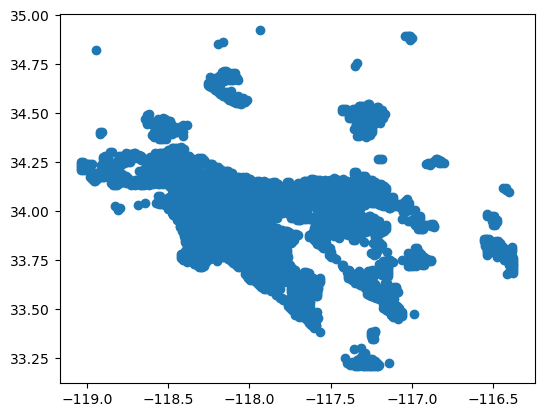

In [7]:
gdf.plot()

<AxesSubplot: >

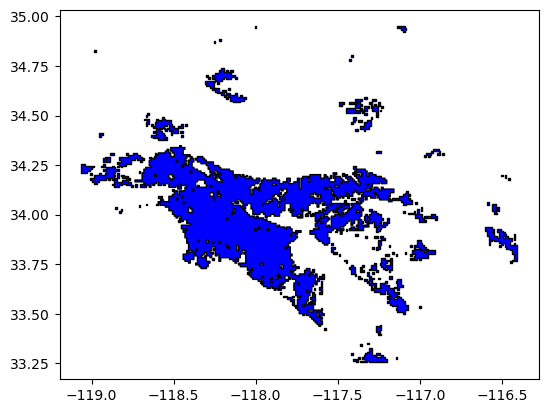

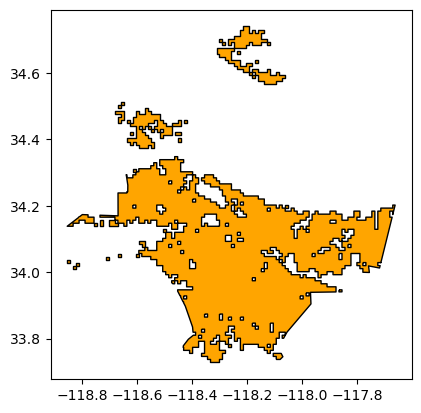

In [8]:
# -------------------------------
# 1. Prepare mask
# -------------------------------
mask = wrf_urban_mask.values.astype(np.uint8)  # 1 = urban, 0 = non-urban

# -------------------------------
# 2. Flip mask vertically for correct orientation
# -------------------------------
mask_flipped = np.flipud(mask)

# -------------------------------
# 3. Build affine transform
# -------------------------------
x2d = wrf_urban_mask['XLONG'].values
y2d = wrf_urban_mask['XLAT'].values

dx = x2d[0,1] - x2d[0,0]
dy = y2d[1,0] - y2d[0,0]

# Top-left origin for rasterio
transform = from_origin(x2d.min() - dx/2, y2d.max() + dy/2, dx, dy)

# -------------------------------
# 4. Extract polygons from mask
# -------------------------------
shapes_gen = rasterio.features.shapes(
    mask_flipped,
    mask=mask_flipped.astype(bool),
    transform=transform
)

geoms = [shape(geom) for geom, value in shapes_gen if value == 1]

# -------------------------------
# 5. Merge all polygons into one geometry
# -------------------------------
merged_geom = unary_union(geoms)

# -------------------------------
# 6. Create GeoDataFrame
# -------------------------------
gdf_urban = gpd.GeoDataFrame({'geometry': [merged_geom]}, crs="EPSG:4326")  # WGS84

# -------------------------------
# 7. Reproject LA County to match CRS
# -------------------------------
la_county_utm = la_county_boundary.to_crs(gdf_urban.crs)

# -------------------------------
# 8. Clip urban polygons to LA County
# -------------------------------
urban_la_county = gdf_urban.overlay(la_county_utm, how='intersection')

# -------------------------------
# 9. Drop empty / invalid geometries
# -------------------------------
urban_la_county = urban_la_county[
    urban_la_county.geometry.notna() & ~urban_la_county.is_empty
]

# -------------------------------
# 10. Quick plot to verify
# -------------------------------
gdf_urban.plot(facecolor='blue', edgecolor='black')
urban_la_county.plot(facecolor='orange', edgecolor='black')

In [9]:
# save urban area in la county as geopandas compatible gpkg
save_path = '/home1/kojoseph/ah-la-paper/data/wrf_urban_mask-v2.gpkg'
urban_la_county.to_file(save_path, driver='GPKG')

In [10]:
print(la_county_boundary.crs)
print(urban_la_county.crs)

epsg:4326
EPSG:4326


<AxesSubplot: >

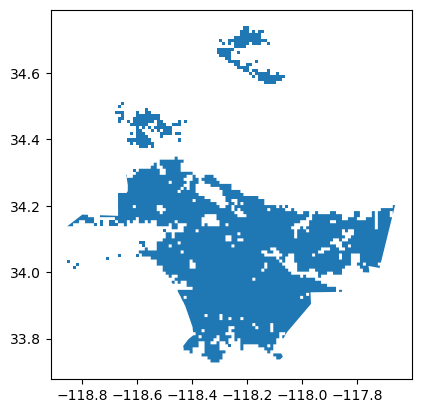

In [11]:
# reload from file to test
test = gpd.read_file(save_path)
test.plot()

# Test clipping WRF output data

In [45]:
# test filtering wrf output files with this mask now
# import a sample wrfout file
wrf_dir = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb_v2'
wrf_filelist = glob.glob(os.path.join(wrf_dir, 'wrfout_d02*'))
ds = xr.open_mfdataset(wrf_filelist, 
                        engine="netcdf4",
                        concat_dim="Time",
                        combine="nested").xwrf.postprocess()
ds = ds.sortby('Time')
wrf_crs = ds.wrf_projection.item()
ds = ds.rio.write_crs(wrf_crs)
# clip wrfout with urban_la_county geometry
ds_clipped = ds.rio.clip(urban_la_county.geometry.values, urban_la_county.crs)
# plot with and without clipping
# v = 'T2'


In [46]:
ds_clipped

<xarray.Dataset>
Dimensions:                    (Time: 217, y: 111, x: 107, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
    wrf_projection             int64 0
    XLAT                       (y, x) float32 dask.array<chunksize=(111, 107), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(111, 107), meta=np.ndarray>
  * x                          (x) float64 1.495e+05 1.505e+05 ... 2.555e+05
  * y                          (y) float64 -3.714e+05 -3.704e+05 ... -2.614e+05
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/98)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    ...                         ...
    PC                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 111, 107), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 111, 107), meta=np.ndarray>
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [ ]:
la_count

In [52]:
ds

<xarray.Dataset>
Dimensions:                    (Time: 217, y: 192, x: 244, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XLAT                       (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
  * x                          (x) float64 1.325e+05 1.335e+05 ... 3.755e+05
  * y                          (y) float64 -4.254e+05 -4.244e+05 ... -2.344e+05
    wrf_projection             int64 0
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/98)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    ...                         ...
    PC                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 192, 244), meta=np.ndarray>
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

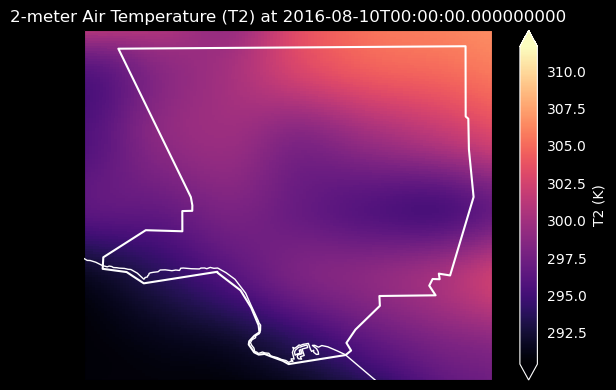

In [53]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select time index (e.g., first timestep)
time_index = 0
t2 = ds['T2'].isel(Time=time_index)  # shape (y, x)

# Get lat/lon
lat = ds['XLAT'].values
lon = ds['XLONG'].values

# Ensure LA county geometry is in lon/lat (EPSG:4326)
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

# Compute extent from LA County bounds with 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx*pad_frac, maxx + dx*pad_frac,
          miny - dy*pad_frac, maxy + dy*pad_frac]

# Create figure
fig = plt.figure(figsize=(6, 4))
fig.patch.set_facecolor('black')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmin = t2.min().compute()
vmax = t2.max().compute()
# Plot T2 as pixel grid (no interpolation)
pcm = ax.pcolormesh(
    lon, lat, t2,
    cmap='magma',
    shading='auto',  # shows raw pixels
    vmin=vmin, vmax=vmax,  # optional fixed range
    zorder=1
)

# Overlay LA County boundary
for geom in la_county_wgs.geometry:
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

# Coastlines
ax.coastlines(color='white', zorder=4)

# Colorbar with white labels
cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label('T2 (K)', color='white')
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
cbar.outline.set_edgecolor('white')

# Title
ax.set_title(f"2-meter Air Temperature (T2) at {ds['Time'].values[time_index]}", color='white')

plt.tight_layout()
plt.show()


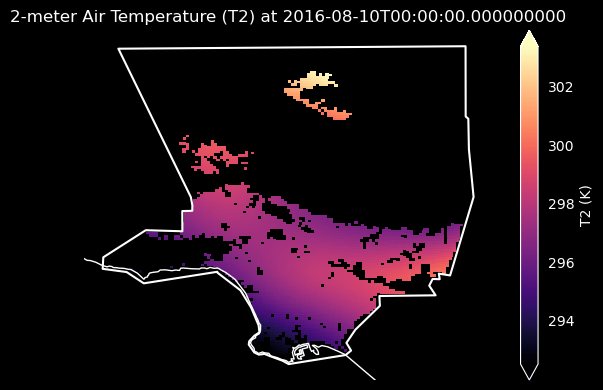

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select time index (e.g., first timestep)
time_index = 0
t2 = ds_clipped['T2'].isel(Time=time_index)  # shape (y, x)

# Get lat/lon
lat = ds_clipped['XLAT'].values
lon = ds_clipped['XLONG'].values

# Ensure LA county geometry is in lon/lat (EPSG:4326)
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

# Compute extent from LA County bounds with 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx*pad_frac, maxx + dx*pad_frac,
          miny - dy*pad_frac, maxy + dy*pad_frac]

# Create figure
fig = plt.figure(figsize=(6, 4))
fig.patch.set_facecolor('black')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmin = t2.min().compute()
vmax = t2.max().compute()
# Plot T2 as pixel grid (no interpolation)
pcm = ax.pcolormesh(
    lon, lat, t2,
    cmap='magma',
    shading='auto',  # shows raw pixels
    vmin=vmin, vmax=vmax,  # optional fixed range
    zorder=1
)

# Overlay LA County boundary
for geom in la_county_wgs.geometry:
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

# Coastlines
ax.coastlines(color='white', zorder=4)

# Colorbar with white labels
cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label('T2 (K)', color='white')
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
cbar.outline.set_edgecolor('white')

# Title
ax.set_title(f"2-meter Air Temperature (T2) at {ds_clipped['Time'].values[time_index]}", color='white')

plt.tight_layout()
plt.show()
